In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

In [3]:
def plotCSNS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1 #actually lon
    fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

## Import data

In [4]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [5]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_ros3','backadm_ros3','backvs_ros3','forpr_haro3','forgulf_haro3','backvs_haro3']
        #  'forvs_haro3','backpr_haro3','backgulf_haro3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2020,12,29)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for var in dicts[file].keys():
        if var not in st_dict:
            st_dict[var] = []
        for section in sectionnum:
            st_dict[var].append(get_datat(dicts[file][var],section,starttime,endtime))
        dict_sectiontransp[file] = st_dict

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            
transp_2018 = {}

for file in files:
    
    transp_2018[file] = []
    
    for date in dates:
        try:
            transp_2018[file].append(np.sum(dict_sectiontransp[file][date][2:]))
        except:
            pass
        
sectransp_2018 = {}

for file in files:
    sectransp_2018[file] = {}
    
    for section in sectionnum:
        if section not in sectransp_2018[file]:
            sectransp_2018[file][section] = []
            
        for date in dates:
            try:
                sectransp_2018[file][section].append(dict_sectiontransp[file][date][section])
            except:
                pass


In [6]:
dict_secdata = {}
sectionnum = [0,1,2,3,4,5,6,7,8]

for file in files:
    
    if file not in dict_secdata:
        dict_secdata[file] = {}
    
    for section in sectionnum:
        
        if section not in dict_secdata[file]:
            
            dict_secdata[file][section] = {}
            
        for date in dicts[file].keys():
            
            if section not in dict_secdata[file]:
            
                dict_secdata[file][section][date] = {}
            
            dict_secdata[file][section][date] = get_secdata(dicts[file][date],section)

In [7]:
month_avg = np.zeros([12,len(sectransp_2018['forpr_ros3'].keys())])

for sectionnum in sectransp_2018['forpr_ros3'].keys():
    intermed = sectransp_2018['forpr_ros3'][sectionnum]
    for month in range(1,13):
        dates = [index for index, date in enumerate(datelist_vs) if date.month == month]
        selected_elements = [sectransp_2018['forpr_ros3'][sectionnum][index] for index in dates]
        month_avg[month-1,sectionnum] = np.mean(selected_elements)
    

In [8]:
dates = [index for index, date in enumerate(datelist_vs) if date.month == 1]
selected_elements = [sectransp_2018['forpr_ros3'][0][index] for index in dates]
date_jan = [datelist_vs for index in dates]

date = dt.datetime(2018,1,1)
enddate = dt.datetime(2019,1,1)

dates = []
datelist_yr = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yr.append(date)
    date+=dt.timedelta(days=31)

In [9]:
datelist_yr

[datetime.datetime(2018, 1, 1, 0, 0),
 datetime.datetime(2018, 2, 1, 0, 0),
 datetime.datetime(2018, 3, 4, 0, 0),
 datetime.datetime(2018, 4, 4, 0, 0),
 datetime.datetime(2018, 5, 5, 0, 0),
 datetime.datetime(2018, 6, 5, 0, 0),
 datetime.datetime(2018, 7, 6, 0, 0),
 datetime.datetime(2018, 8, 6, 0, 0),
 datetime.datetime(2018, 9, 6, 0, 0),
 datetime.datetime(2018, 10, 7, 0, 0),
 datetime.datetime(2018, 11, 7, 0, 0),
 datetime.datetime(2018, 12, 8, 0, 0)]

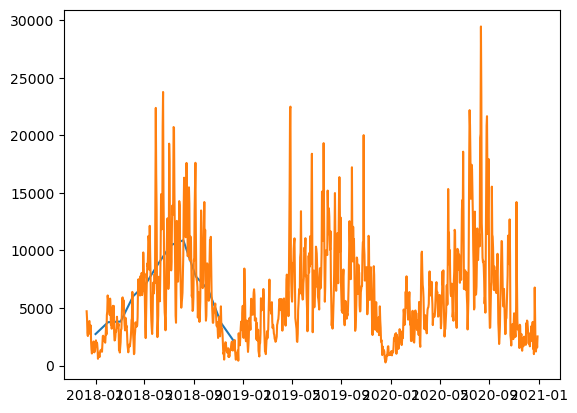

In [10]:
plt.plot(datelist_yr,month_avg[:,4])
plt.plot(datelist_vs,sectransp_2018['forpr_ros3'][4])

### Shifting functions

In [11]:
def shift_time(dfr,dfr_age,datelist,base,factor):
    shifted_time = [date + dt.timedelta(days=base+factor*dfr_age[i]/24) for i,date in enumerate(datelist)]
    dfr = pd.DataFrame({'Transport':dfr.values,'Shifted_Time': shifted_time},index=dfr.index)
    return dfr

def merge(dfr,dfr2):
    """Aligns shifted dateframes to calculate correlation

    Args:
        dfr : Forward dataframe
        dfr2 (_type_): Backward dataframe

    Returns:
        _type_: Aligned, shifted dataframes and correlation between the 2.
    """
    
    oidx = dfr.index
    ndfr = dfr.set_index('Shifted_Time')
    nidx = ndfr.index
    
    step1 = ndfr.reindex(nidx.union(oidx)) # Creates dataframe with row of each old and new index ( no overlap - 128 rows now)
    step2 = step1.sort_index() # Sorts into chronological order
    step3 = step2.interpolate(axis=0) # Interpolates in between (since dates dont line up)
    fdfr = step3
    
    #Same for 2nd dataframe
    oidx2 = dfr2.index
    ndfr2 = dfr2.set_index('Shifted_Time')
    nidx2 = ndfr2.index
    
    step1 = ndfr2.reindex(nidx2.union(oidx2))
    step2 = step1.sort_index()
    step3 = step2.interpolate(axis=0)
    fdfr2 = step3
    
    corr = fdfr.Transport.corr(fdfr2.Transport) #Correlation ignores nan values
    
    avg = 0.5*(fdfr.Transport + fdfr2.Transport)
    return fdfr,fdfr2,corr,avg

### Import density data

In [12]:
# Importing density and tidal data

density_ros = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/notebooks/sigma_2017-22_rosarioNS.csv')
dens_diff_ros = np.array(density_ros.south - density_ros.north)

# density_rosVS = pd.read_csv('sigma_2018_rosariopr_202111_meanv2.csv')
# dens_diff_rosVS = np.array(density_rosVS.south - density_rosVS.north)

# density_haro = pd.read_csv('sigma_2018_harovs_202111_mean_v2.csv')
# dens_diff_haro = np.array(density_haro.south - density_haro.north)

density_vspr = pd.read_csv('../notebooks/sigma_2017-22_202111_mean.csv')
dens_diff_vspr = np.array(density_vspr.south - density_vspr.north)

tides = pd.read_csv('../notebooks/low_pass_tide_2018-22_BP.csv')
# tides = pd.read_csv('low_pass_tide_18-22.csv').iloc[:730,:]


date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_tides = []

while date <= enddate:
    datelist_tides.append(date)
    date+=dt.timedelta(days=1)

#Confirm dates are same length

print(len(datelist_tides))
print(tides.iloc[:,1].shape)   
 
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_dens = []

while date <= enddate:
    datelist_dens.append(date)
    date+=dt.timedelta(days=1)
    
dens_diff_ros
print(len(datelist_dens))
print(dens_diff_ros.size)

2191
(2191,)
2191
2191


In [13]:
tides['vozocrtx']

0            NaN
1            NaN
2       0.607365
3       0.508302
4       0.436066
          ...   
2186    0.908305
2187    0.787567
2188    0.629463
2189    0.472127
2190         NaN
Name: vozocrtx, Length: 2191, dtype: float64

In [31]:
wind = pd.read_csv('../notebooks/day_avg_wind_17-22.csv')
x = wind['time']
y = wind['wind']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_winds = []

while date <= enddate:
    datelist_winds.append(date)
    date+=dt.timedelta(days=1)
    
y_mean4 = y.rolling(window=4, center=True).mean()

#### Rosario to adm

In [15]:
PRtoadm_rosl = sectransp_2018['forpr_ros3'][2]
PRtoadm_rosbl = sectransp_2018['backadm_ros3'][4]

PRtoadm_ros = pd.Series(PRtoadm_rosl,index=datelist_vs)
PRtoadm_rosb = pd.Series(PRtoadm_rosbl,index=datelist_vs)

In [16]:
PRtoadm_rosb

2017-12-10     820.595292
2017-12-11    1149.001901
2017-12-12     749.904988
2017-12-13     707.988881
2017-12-14     889.198318
                 ...     
2020-12-25     535.120941
2020-12-26     473.116671
2020-12-27    1021.656706
2020-12-28    1466.900046
2020-12-29    2052.967028
Length: 1116, dtype: float64

In [17]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base,factor)
        dfr2 = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.65:
            print (base, factor, corr_arr[i, j])

In [18]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[0.05] [0.15]


0.5995333668855547


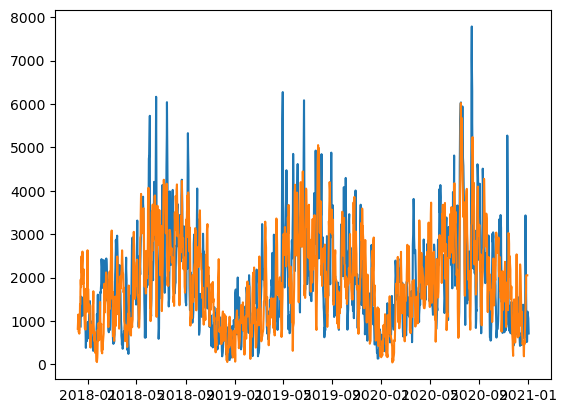

In [19]:
PRtoadm_ros_sh = shift_time(PRtoadm_ros,age_2018['forpr_ros3'][2],datelist_vs,base_adm[0],factor_adm[0])
PRtoadm_rosb_sh = shift_time(PRtoadm_rosb,age_2018['backadm_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtoadm_ros_m,PRtoadm_rosb_m,c,PRtoadm_ros_avg = merge(PRtoadm_ros_sh,PRtoadm_rosb_sh)
print(c)

plt.plot(PRtoadm_ros_m.Transport)
plt.plot(PRtoadm_rosb_m.Transport)

### PR to VicSill

In [20]:
PRtovs_rosl = sectransp_2018['forpr_ros3'][4]
PRtovs_rosbl = sectransp_2018['backvs_ros3'][4]

PRtovs_ros = pd.Series(PRtovs_rosl,index=datelist_vs)
PRtovs_rosb = pd.Series(PRtovs_rosbl,index=datelist_vs)

In [21]:
PRtovs_rosb

2017-12-10    1310.770747
2017-12-11    1871.730525
2017-12-12    1910.283706
2017-12-13    3093.747551
2017-12-14    5417.023974
                 ...     
2020-12-25    4339.805115
2020-12-26    5427.410232
2020-12-27    5136.434624
2020-12-28    4947.487158
2020-12-29    5741.133435
Length: 1116, dtype: float64

In [22]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.73:
            print (base, factor, corr_arr[i, j])

-1.0 0.30000000000000115 0.7307582783779973
-0.7999999999999998 0.2500000000000011 0.7314928540370331
-0.7499999999999998 0.2500000000000011 0.7349859880873802
-0.6999999999999997 0.2500000000000011 0.7338865457512355
-0.6499999999999997 0.2500000000000011 0.7346289995077869
-0.5999999999999996 0.2500000000000011 0.7333050100089101
-0.5499999999999996 0.2500000000000011 0.7301369370970698
-0.49999999999999956 0.2500000000000011 0.7311649859657814
-0.4499999999999995 0.2500000000000011 0.7300339688210415
-0.3499999999999994 0.2500000000000011 0.7314006796627408


In [23]:
i_base_adm,i_factor_adm = np.where(corr_arr==np.max(corr_arr))

base_adm = base_arr[i_base_adm]
factor_adm = factor_arr[i_factor_adm]

print(base_adm,factor_adm)

[-0.75] [0.25]


0.7349859880873802


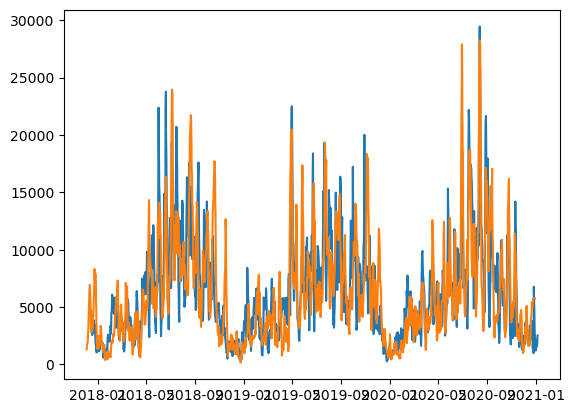

In [24]:
PRtovs_ros_sh = shift_time(PRtovs_ros,age_2018['forpr_ros3'][4],datelist_vs,base_adm[0],factor_adm[0])
PRtovs_rosb_sh = shift_time(PRtovs_rosb,age_2018['backvs_ros3'][4],datelist_vs,-base_adm[0],-factor_adm[0])

PRtovs_ros_m,PRtovs_rosb_m,c,PRtovs_ros_avg = merge(PRtovs_ros_sh,PRtovs_rosb_sh)
print(c)

plt.plot(PRtovs_ros_m.Transport)
plt.plot(PRtovs_rosb_m.Transport)

0.8145035162664623


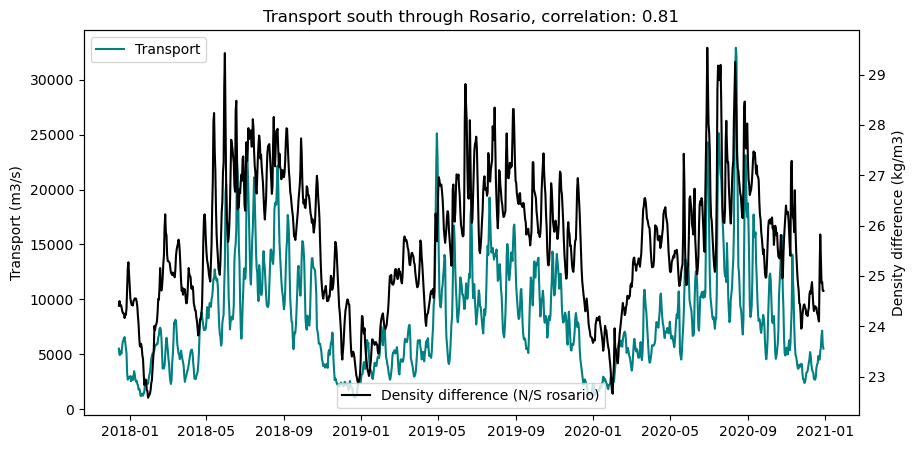

In [25]:
rostosouth = PRtovs_ros_avg.dropna() + PRtoadm_ros_avg.dropna()
date_rossh = list(rostosouth.dropna().index)

mask = np.isin(datelist_dens,date_rossh)
densdiff_ros = dens_diff_ros[mask]
# densdiff_ros2 = dens_diff_rosVS[mask]
date_dens_sh = np.array(datelist_dens)[mask]

corr_rostosouth,p = stats.spearmanr(densdiff_ros,rostosouth.dropna())
print(corr_rostosouth)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_sh,densdiff_ros,color='k',label='Density difference (N/S rosario)')
ax.set_title(f'Transport south through Rosario, correlation: {np.round(corr_rostosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

In [26]:
dens_diff_ros.shape

(2191,)

2840.2989513120788 -64657.39597291925


Text(0.5, 1.0, 'South through rosario, correlation = -0.131')

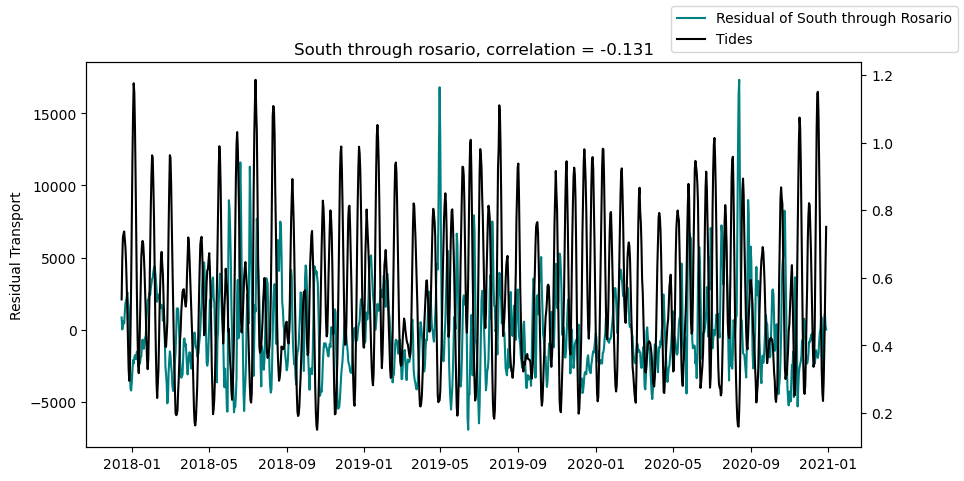

In [27]:
slope,intercept = np.polyfit(densdiff_ros,rostosouth.dropna(),1)
ddline = slope*densdiff_ros+intercept
res = rostosouth.dropna() - ddline
print(slope,intercept)

# slope,intercept = np.polyfit(densdiff_ros2,rostosouth.dropna(),1)
# ddline2 = slope*densdiff_ros2+intercept
# res_ros2 = rostosouth.dropna() - ddline2

mask = np.isin(datelist_tides,date_rossh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides.vozocrtx[mask]

corr_res_ros,p = stats.spearmanr(tides_sh,res)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'South through rosario, correlation = {np.round(corr_res_ros,3)}')

In [28]:
tides.vozocrtx,len(datelist_tides)

(0            NaN
 1            NaN
 2       0.607365
 3       0.508302
 4       0.436066
           ...   
 2186    0.908305
 2187    0.787567
 2188    0.629463
 2189    0.472127
 2190         NaN
 Name: vozocrtx, Length: 2191, dtype: float64,
 2191)

Text(0.5, 1.0, 'corr = -0.211')

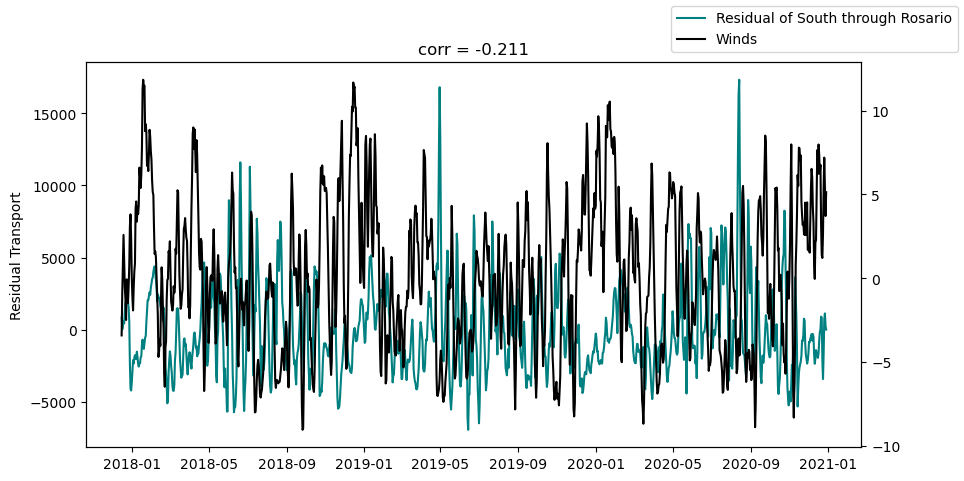

In [32]:
mask = np.isin(datelist_winds,date_rossh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_sh = y_mean4[mask]

corr_res_ros_wind,p = stats.spearmanr(winds_sh,res)
corr_res_ros_wind

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_sh,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr_res_ros_wind,3)}')

### Through Haro

Now need:
- PR to adm
- PR to VS
- Gulf to adm
- Gulf to VS

4 and then combine them as before

#### PR to VicSill

In [33]:
PRtovs_harol = sectransp_2018['forpr_haro3'][6]
PRtovs_harobl = sectransp_2018['backvs_haro3'][6]

PRtovs_haro = pd.Series(PRtovs_harol,index=datelist_vs)
PRtovs_harob = pd.Series(PRtovs_harobl,index=datelist_vs)

In [34]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(PRtovs_haro,age_2018['forpr_haro3'][6],datelist_vs,base,factor)
        dfr2 = shift_time(PRtovs_harob,age_2018['backvs_haro3'][6],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.66:
            print (base, factor, corr_arr[i, j])

In [35]:
i_base_vs_haro,i_factor_vs_haro = np.where(corr_arr==np.max(corr_arr))

base_vs_haro = base_arr[i_base_vs_haro]
factor_vs_haro = factor_arr[i_factor_vs_haro]

print(base_vs_haro,factor_vs_haro)

[-0.65] [0.25]


0.5927556369780689


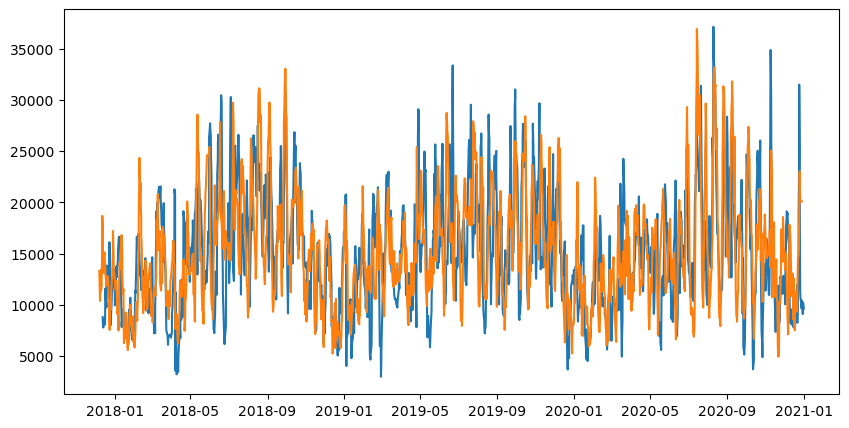

In [36]:
PRtovs_haro_sh = shift_time(PRtovs_haro,age_2018['forpr_haro3'][5],datelist_vs,base_vs_haro[0],factor_vs_haro[0])
PRtovs_harob_sh = shift_time(PRtovs_harob,age_2018['backvs_haro3'][6],datelist_vs,-base_vs_haro[0],-factor_vs_haro[0])

PRtovs_haro_m,PRtovs_harob_m,c,PRtovs_haro_avg = merge(PRtovs_haro_sh,PRtovs_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(PRtovs_haro_m.Transport)
ax.plot(PRtovs_harob_m.Transport)

Why do these 2 look so different????

#### PR to adm

These is essentially insignificant when comparing to whats going to VicSill -> ignore PR to adm

#### Gulf to VicSill

In [38]:
Gulftovs_harol = sectransp_2018['forgulf_haro3'][7]
Gulftovs_harobl = sectransp_2018['backvs_haro3'][7]

Gulftovs_haro = pd.Series(Gulftovs_harol,index=datelist_vs)
Gulftovs_harob = pd.Series(Gulftovs_harobl,index=datelist_vs)

In [39]:
# Loop through different base and factors to find which combination maximizes the correlation

factor_arr = np.arange(-1,1,0.05)
base_arr = np.arange(-1,1,0.05)

corr_arr = np.zeros([len(base_arr),len(factor_arr)])

for i,base in enumerate(base_arr):
    for j,factor in enumerate(factor_arr):
        dfr1 = shift_time(Gulftovs_haro,age_2018['forgulf_haro3'][7],datelist_vs,base,factor)
        dfr2 = shift_time(Gulftovs_harob,age_2018['backvs_haro3'][7],datelist_vs,-base,-factor)
        dfr1_sh,dfr2_sh,corr_arr[i,j],a = merge(dfr1,dfr2)
        if corr_arr[i,j] > 0.69:
            print (base, factor, corr_arr[i, j])

In [40]:
i_base_gulfvs_haro,i_factor_gulfvs_haro = np.where(corr_arr==np.max(corr_arr))

base_gulfvs_haro = base_arr[i_base_gulfvs_haro]
factor_gulfvs_haro = factor_arr[i_factor_gulfvs_haro]

print(base_gulfvs_haro,factor_gulfvs_haro)

[0.95] [0.3]


0.3669882654348646


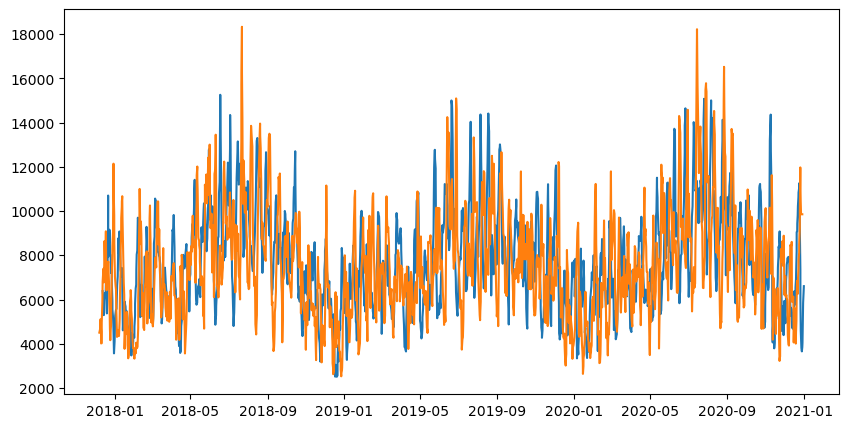

In [41]:
Gulftovs_haro_sh = shift_time(Gulftovs_haro,age_2018['forgulf_haro3'][7],datelist_vs,base_vs_haro[0],factor_vs_haro[0])
Gulftovs_harob_sh = shift_time(Gulftovs_harob,age_2018['backvs_haro3'][7],datelist_vs,-base_vs_haro[0],-factor_vs_haro[0])

Gulftovs_haro_m,Gulftovs_harob_m,c,Gulftovs_haro_avg = merge(Gulftovs_haro_sh,Gulftovs_harob_sh)
print(c)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(Gulftovs_haro_m.Transport)
ax.plot(Gulftovs_harob_m.Transport)

Gulf to VicSill more significnt than PointRob to VicSill

#### Gulf to adm

Gulf to admiralty also basically insignificant

Text(0, 0.5, 'Transport (m3/s)')

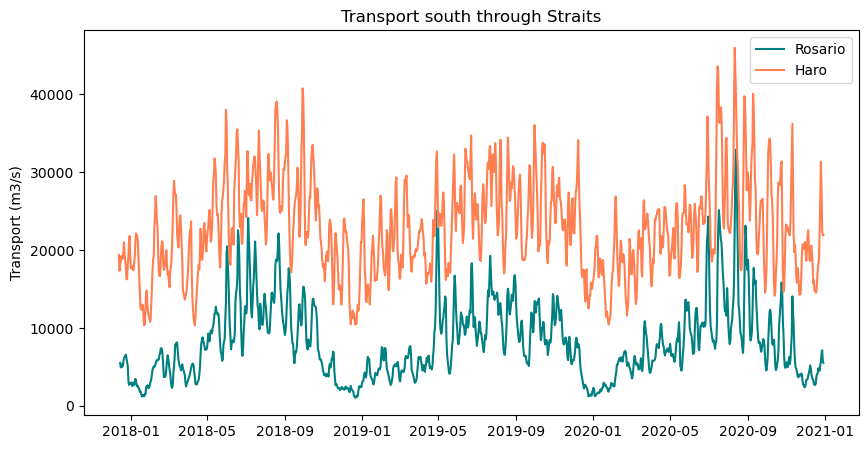

In [43]:
harotosouth = PRtovs_haro_avg + Gulftovs_haro_avg
date_harosh = list(harotosouth.dropna().index)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(rostosouth.dropna(),label='Rosario',color='teal')
ax.plot(harotosouth.dropna(),label='Haro',color='coral')
ax.legend()
ax.set_title(f'Transport south through Straits')
ax.set_ylabel('Transport (m3/s)')

In [48]:
corr_haroros,p = stats.spearmanr(rostosouth.dropna(),harotosouth.dropna()[2:])
print(corr_haroros)

0.7310878715715241


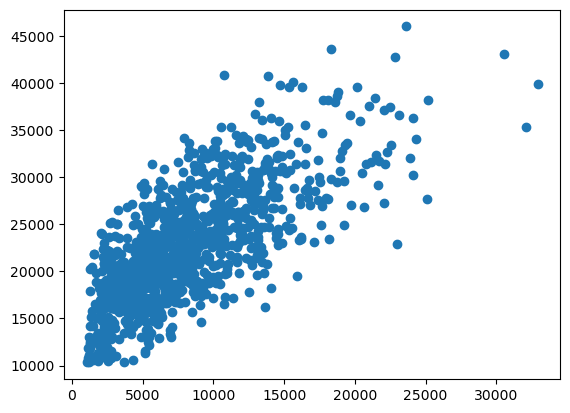

In [51]:
plt.scatter(rostosouth.dropna(),harotosouth.dropna()[2:])

#### Correlations with transport south through Haro

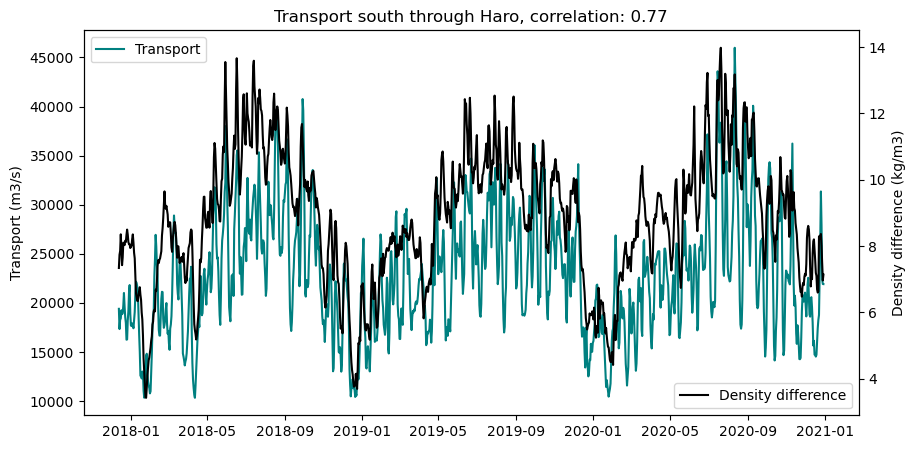

In [52]:
date_harosh = list(harotosouth.dropna().index)

mask = np.isin(datelist_dens,date_harosh)
densdiff_haro = dens_diff_vspr[mask]
date_dens_haro_sh = np.array(datelist_dens)[mask]

corr_harotosouth,p = stats.spearmanr(densdiff_haro,harotosouth.dropna())

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotosouth.dropna(),color='teal',label='Transport')
ax2=ax.twinx()
ax2.plot(date_dens_haro_sh,densdiff_haro,color='k',label='Density difference')
ax.set_title(f'Transport south through Haro, correlation: {np.round(corr_harotosouth,2)}')
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Density difference (kg/m3)')
ax.legend(loc=2)
ax2.legend()

Find density difference N/S through Haro to increase this correlation?

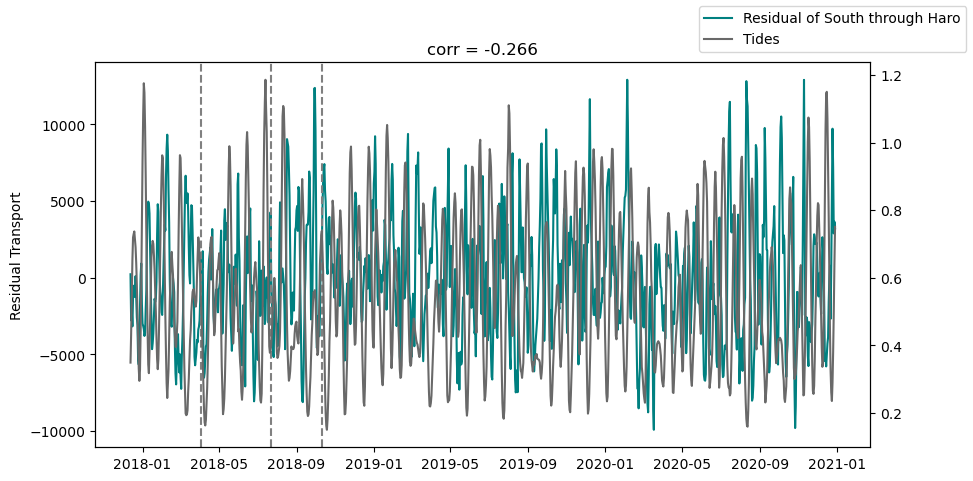

In [54]:
slope,intercept = np.polyfit(densdiff_haro,harotosouth.dropna(),1)
ddline_haro = slope*densdiff_haro+intercept
res_haro = harotosouth.dropna() - ddline_haro

mask = np.isin(datelist_tides,date_harosh)
date_tides_haro_sh = np.array(datelist_tides)[mask]
tides_haro_sh = tides.vozocrtx[mask]

corr_res_haro,p = stats.spearmanr(tides_haro_sh,res_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_tides_haro_sh,tides_haro_sh,color='dimgrey',label='Tides')
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr_res_haro,3)}')
# ax.plot(rostosouth.dropna(),label='Transport south through Rosario')
# ax.plot(res,label='Residual south through Rosario',color='darkblue')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[300],ls='--',color='grey')
# ax3 = ax.twinx()
# ax3.plot(date_winds_sh,winds_sh,color='darkgrey',label='Winds')
# ax3.spines['right'].set_position(('outward', 80))
fig.legend()

Text(0, 0.5, 'Wind velocity')

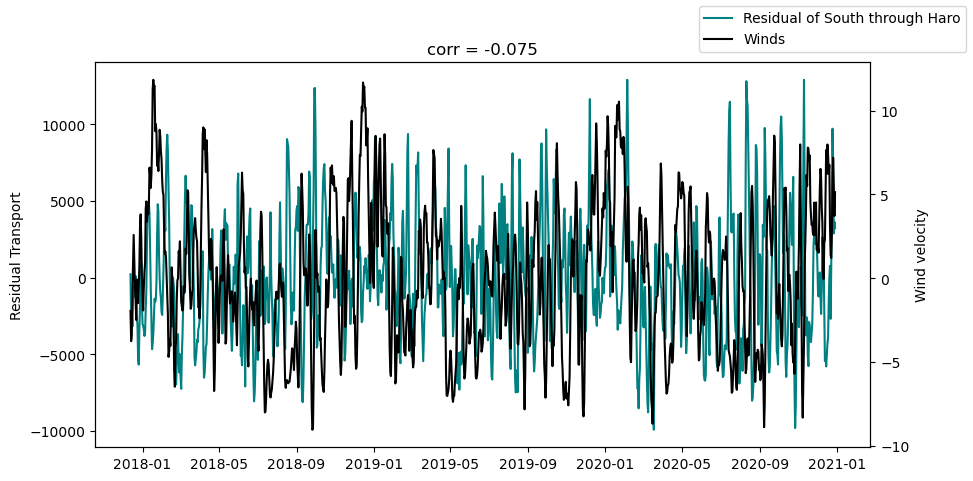

In [55]:
mask = np.isin(datelist_winds,date_harosh)
date_winds_sh = np.array(datelist_winds)[mask]
winds_haro = y_mean4[mask]

corr,p = stats.spearmanr(winds_haro,res_haro)
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res_haro,color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_winds_sh,winds_haro,color='k',label='Winds')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax2.set_ylabel('Wind velocity')

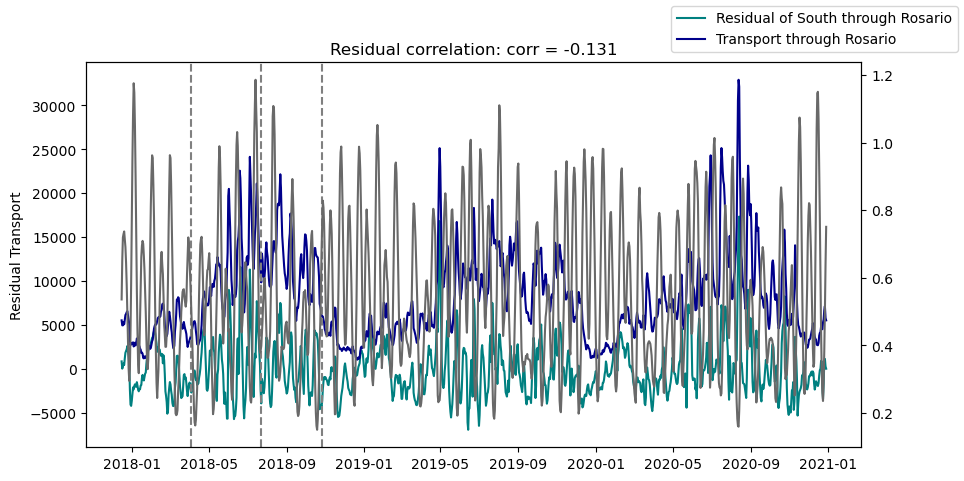

In [56]:
corr,p = stats.spearmanr(winds_haro,res_haro)
corr

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(res,color='teal',label='Residual of South through Rosario')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='dimgrey')
ax.plot(rostosouth.dropna(),color='darkblue',label='Transport through Rosario')
# ax.plot(harotosouth.dropna(),color='sienna',label='Transport through Haro')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'Residual correlation: corr = {np.round(corr_res_ros,3)}')
ax.axvline(date_tides_sh[110],ls='--',color='grey')
ax.axvline(date_tides_sh[220],ls='--',color='grey')
ax.axvline(date_tides_sh[315],ls='--',color='grey')

Look at correlation in zone 2 of tides with residual Rosario transport. Zone 2 looks like its better (inversely) correlated with the tides than the others

In [57]:
wind.wind[349]
winds_sh

348    -3.405873
349    -0.862762
350     0.768392
351     2.586593
352     1.167137
          ...   
1454    5.471588
1455    7.196392
1456    5.588128
1457    3.716670
1458    5.135701
Name: wind, Length: 1111, dtype: float64

#### Split into sub regions to check correlation

In [59]:
slope,intercept = np.polyfit(winds_haro[303:351],res_haro[303:351],1)
wind_line_haro = slope*winds_haro[303:351]+intercept
res_haro_wind = res_haro[303:351].values - wind_line_haro

corr,p = stats.spearmanr(tides_haro_sh[303:351],res_haro_wind)
print(corr)

slope,intercept = np.polyfit(winds_sh[300:348],res[300:348],1)
wind_line_ros = slope*winds_sh[300:348]+intercept
res_ros_wind = res[300:348].values - wind_line_ros

corr,p = stats.spearmanr(tides_sh[300:348],res_ros_wind)
print(corr)

-0.016608771168041683
-0.4322622666087712


Text(0, 0.5, 'Tide velocity ')

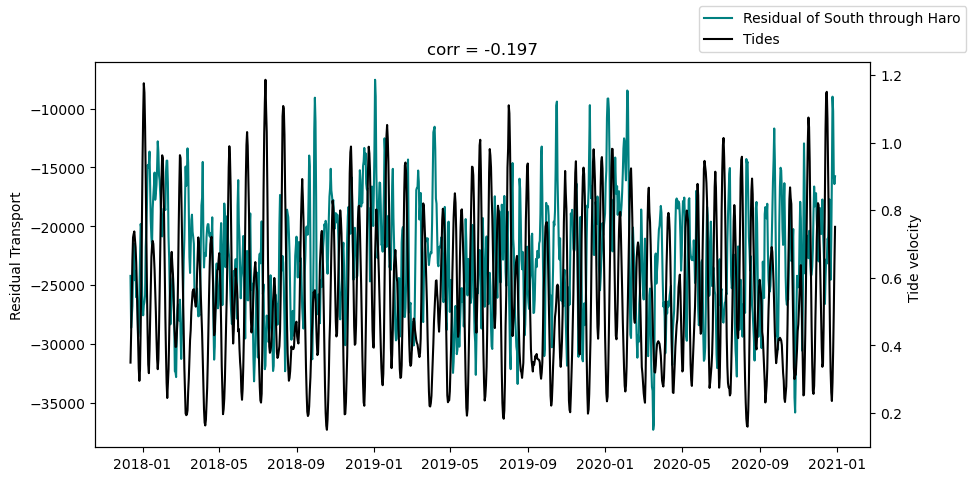

In [60]:
slope,intercept = np.polyfit(winds_haro,harotosouth.dropna(),1)
wline_haro = slope*winds_haro+intercept
resw_haro = res_haro.values - wline_haro

mask = np.isin(datelist_tides,date_winds_sh)
date_tides_sh = np.array(datelist_tides)[mask]
tides_sh = tides.vozocrtx[mask]

corr,p = stats.spearmanr(tides_sh,resw_haro)

fig,ax = plt.subplots(figsize=(10,5))
ax.plot(date_tides_sh,resw_haro,color='teal',label='Residual of South through Haro')
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='k',label='Tides')
fig.legend()
ax.set_ylabel('Residual Transport')
ax.set_title(f'corr = {np.round(corr,3)}')
ax2.set_ylabel('Tide velocity ')

-0.17781865039164382


Text(0.5, 1.0, 'Haro South and Tides')

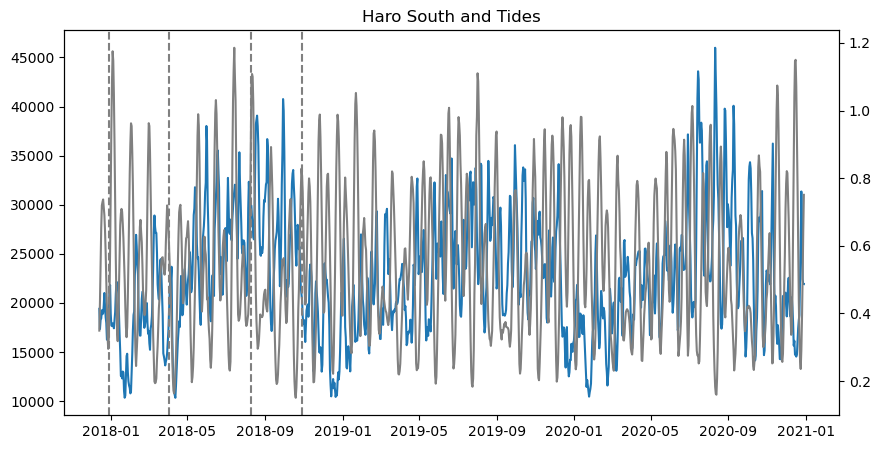

In [61]:
idx_z1 = 15
idx_z2 = 110
idx_z3 = 240
idx_z4 = 320

corr,p = stats.spearmanr(tides_haro_sh,harotosouth.dropna())
print(corr)
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(harotosouth.dropna())
ax2 = ax.twinx()
ax2.plot(date_tides_sh,tides_sh,color='grey')
ax.axvline(date_tides_sh[idx_z2],ls='--',color='grey')
ax.axvline(date_tides_sh[idx_z3],ls='--',color='grey')
ax.axvline(date_tides_sh[idx_z4],ls='--',color='grey')
ax.axvline(date_tides_sh[idx_z1],ls='--',color='grey')
ax.set_title('Haro South and Tides')

### Fraser River discharge

In [62]:
# Import data and take mean

FR_data = pd.read_csv('/ocean/cstang/MOAD/analysis-camryn/Ariane/FR_discharge.csv')
FR_4mean = FR_data['Discharge (m3/s)'].rolling(window=4,center=True).mean()

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)

dates = []
datelist_FR = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_FR.append(date)
    date += dt.timedelta(days=1)

### All runoff (add climatology for other rivers)

In [63]:
rivers = xr.open_dataset('/data/SalishSeaCast/rivers-climatology/watershed_climatologies/Salish_allrivers_daily.nc')
clim = np.zeros(365)

for river in rivers.data_vars:
    clim += rivers[river][0:]
    
clim -= rivers['fraser']

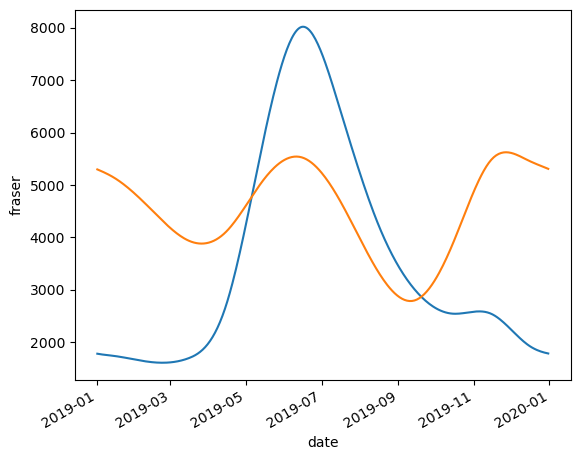

In [64]:
rivers['fraser'].plot()
clim.plot()

In [65]:
date = dt.datetime(2020,1,1)
enddate = dt.datetime(2020,12,31)
dates = []
datelist_2020 = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_2020.append(date)
    date += dt.timedelta(days=1)

idx_leap = datelist_2020.index(dt.datetime(2020,2,29))

clim2020 = np.insert(clim,idx_leap,(clim[58]+clim[59])/2)

clim1718 = np.append(clim,clim)
clim1719 = np.append(clim1718,clim)
clim1720 = np.append(clim1719,clim2020)
clim1721 = np.append(clim1720,clim)
clim1722 = np.append(clim1721,clim)
len(clim1722)

2191

In [66]:
date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)
datelist_yrs = []
dates = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_yrs.append(date)
    date += dt.timedelta(days=1)
       
df_FR_4mean = pd.DataFrame(FR_4mean.values,index=datelist_FR)
df_clim = pd.DataFrame(clim1722,index=datelist_yrs)

runoff = df_FR_4mean.add(df_clim, fill_value=0)

-0.054746472337950894


Text(0.5, 1.0, 'Haro')

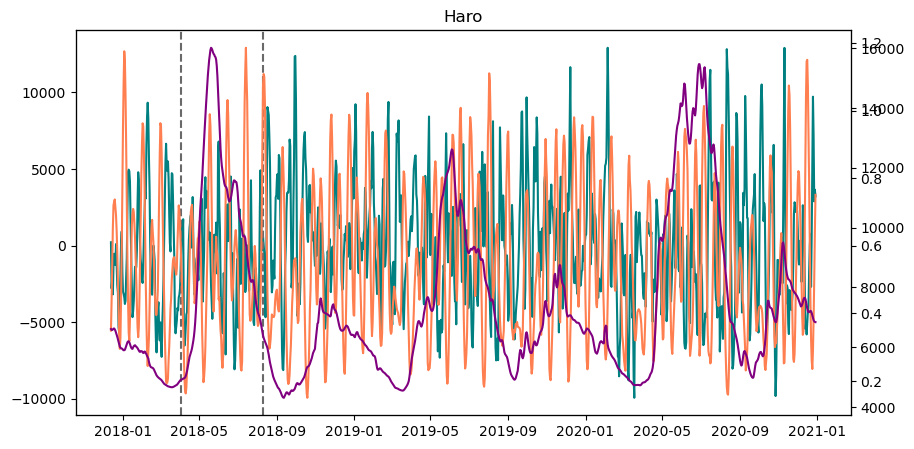

In [67]:
mask = np.isin(datelist_yrs,date_harosh)
runoff_haro = runoff[0].values[mask]

corr,p = stats.spearmanr(runoff_haro,res_haro)
print(corr)

fig,ax = plt.subplots(figsize=(10,5))

ax.plot(res_haro,color='teal')
ax2 = ax.twinx()
ax2.plot(date_harosh,tides_haro_sh,color='coral')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_harosh,runoff_haro,color='purple')
ax.axvline(date_harosh[110],color='dimgrey',ls='--')
ax.axvline(date_harosh[240],color='dimgrey',ls='--')
ax.set_title('Haro')

0.2021139166177334
-0.3560747791175627
-0.5067511214300205


Text(0, 0.5, 'Fraser river flow')

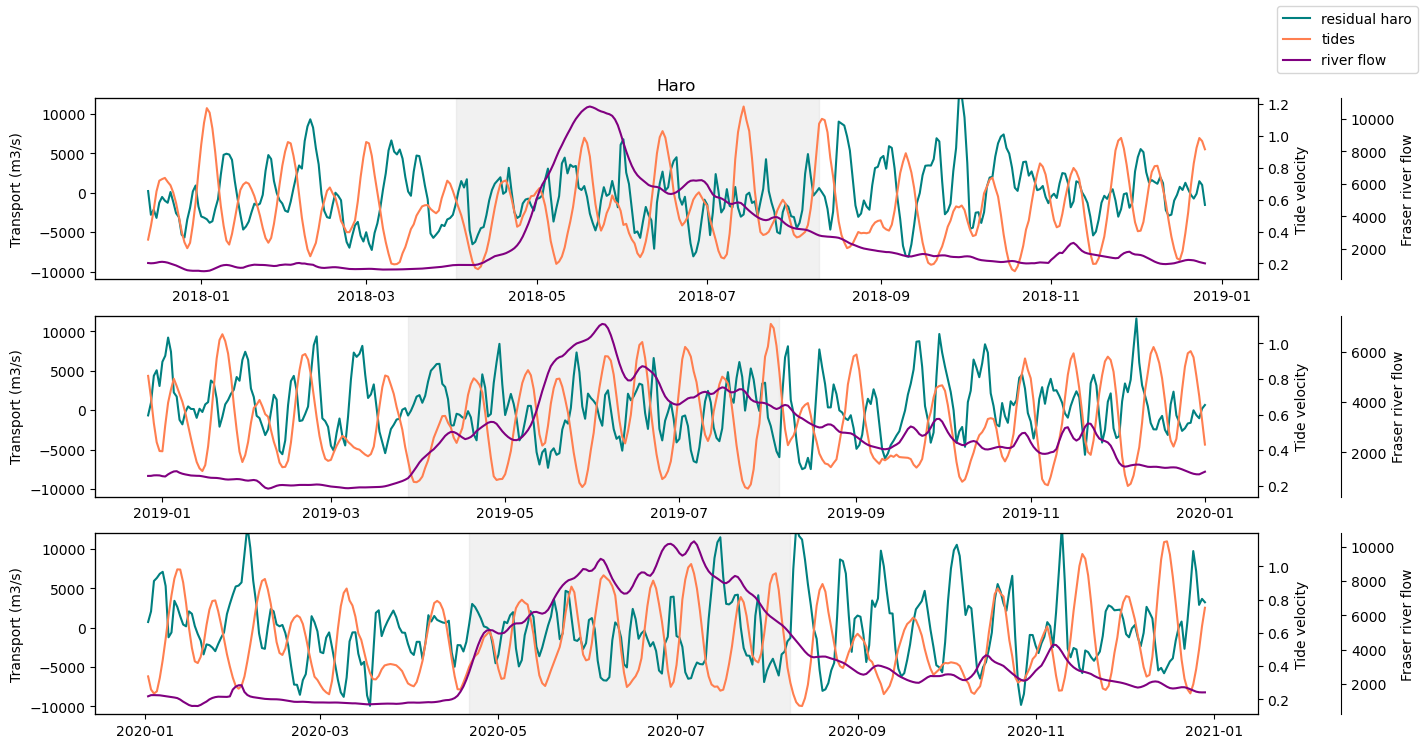

In [91]:
mask = np.isin(datelist_yrs,date_harosh)
FR_haro = FR_4mean[mask]

corr,p = stats.spearmanr(tides_haro_sh[110:240],res_haro[110:240])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[470:600],res_haro[470:600])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[860:970],res_haro[860:970])
print(corr)


fig,[ax,ax4,ax5] = plt.subplots(3,1,figsize=(15,8))

ax.plot(res_haro[0:379],color='teal',label='residual haro')
ax2 = ax.twinx()
ax2.plot(date_harosh[0:379],tides_haro_sh[0:379],color='coral',label='tides')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_harosh[0:379],FR_haro[0:379],color='purple',label='river flow')
ax.set_title('Haro')
ax.set_ylim([-11000,12000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_harosh[110],x2=date_harosh[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('Tide velocity')
ax3.set_ylabel('Fraser river flow')
fig.legend()

ax4.plot(res_haro[379:750],color='teal')
ax42 = ax4.twinx()
ax42.plot(date_harosh[379:750],tides_haro_sh[379:750],color='coral')
ax43 = ax4.twinx()
# ax3.plot(haro_btrop,color='coral')
ax43.plot(date_harosh[379:750],FR_haro[379:750],color='purple')
# ax4.set_title('Haro')
ax4.set_ylim([-11000,12000])
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_harosh[470],x2=date_harosh[600],color='lightgrey', alpha=0.3)
ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('Tide velocity')
ax43.set_ylabel('Fraser river flow')

ax5.plot(res_haro[750:],color='teal')
ax52 = ax5.twinx()
ax52.plot(date_harosh[750:],tides_haro_sh[750:],color='coral')
ax53 = ax5.twinx()
# ax3.plot(haro_btrop,color='coral')
ax53.plot(date_harosh[750:],FR_haro[750:],color='purple')
# ax5.set_title('Haro')
ax5.set_ylim([-11000,12000])
ax5.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_harosh[860],x2=date_harosh[970],color='lightgrey', alpha=0.3)
ax53.spines['right'].set_position(('outward', 60))
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('Tide velocity')
ax53.set_ylabel('Fraser river flow')

The positive correlation doesn't happen in 2019 or 2020

In [93]:
corr,p = stats.spearmanr(tides_haro_sh[110:240],res_haro[110:240])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[470:600],res_haro[470:600])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[860:970],res_haro[860:970])
print(corr)

corr,p = stats.spearmanr(tides_haro_sh[:379],res_haro[:379])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[379:750],res_haro[379:750])
print(corr)
corr,p = stats.spearmanr(tides_haro_sh[750:],res_haro[750:])
print(corr)

0.2021139166177334
-0.3560747791175627
-0.5067511214300205
-0.19339002739919278
-0.2607972984722833
-0.3513779038640917


#### Look with SSH

In [107]:
ssh_jdf_data = pd.read_csv('../notebooks/ssh_jdf_4day_mean_17-22.csv')
ssh_jdf = ssh_jdf_data['SSH']

date = dt.datetime(2017,1,1)
enddate = dt.datetime(2022,12,31)

dates = []
datelist_ssh = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_ssh.append(date)
    date+=dt.timedelta(days=1)

mask = np.isin(datelist_ssh,date_harosh)
ssh_jdf_sh = ssh_jdf[mask]

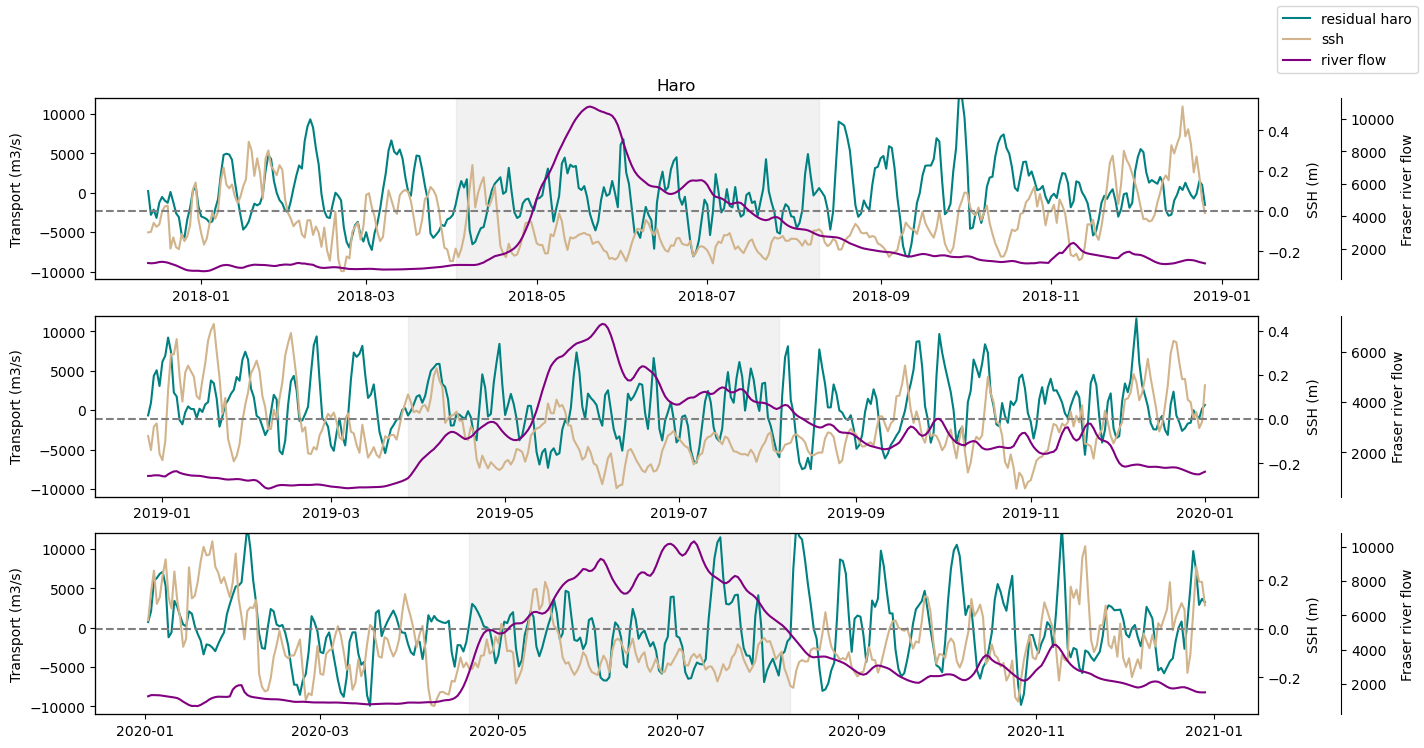

In [116]:
fig,[ax,ax4,ax5] = plt.subplots(3,1,figsize=(15,8))

ax.plot(res_haro[0:379],color='teal',label='residual haro')
ax2 = ax.twinx()
ax2.plot(date_harosh[0:379],ssh_jdf_sh[0:379],color='tan',label='ssh')
ax3 = ax.twinx()
# ax3.plot(haro_btrop,color='coral')
ax3.plot(date_harosh[0:379],FR_haro[0:379],color='purple',label='river flow')
ax.set_title('Haro')
ax.set_ylim([-11000,12000])
ax.fill_betweenx(y=np.linspace(ax.get_ylim()[0], ax.get_ylim()[1], 100),x1=date_harosh[110],x2=date_harosh[240],color='lightgrey', alpha=0.3)
ax3.spines['right'].set_position(('outward', 60))
ax.set_ylabel('Transport (m3/s)')
ax2.set_ylabel('SSH (m)')
ax3.set_ylabel('Fraser river flow')
fig.legend()

ax4.plot(res_haro[379:750],color='teal')
ax42 = ax4.twinx()
ax42.plot(date_harosh[379:750],ssh_jdf_sh[379:750],color='tan')
ax43 = ax4.twinx()
# ax3.plot(haro_btrop,color='coral')
ax43.plot(date_harosh[379:750],FR_haro[379:750],color='purple')
# ax4.set_title('Haro')
ax4.set_ylim([-11000,12000])
ax4.fill_betweenx(y=np.linspace(ax4.get_ylim()[0], ax4.get_ylim()[1], 100),x1=date_harosh[470],x2=date_harosh[600],color='lightgrey', alpha=0.3)
ax43.spines['right'].set_position(('outward', 60))
ax4.set_ylabel('Transport (m3/s)')
ax42.set_ylabel('SSH (m)')
ax43.set_ylabel('Fraser river flow')

ax5.plot(res_haro[750:],color='teal')
ax52 = ax5.twinx()
ax52.plot(date_harosh[750:len(ssh_jdf_sh)],ssh_jdf_sh[750:],color='tan')
ax53 = ax5.twinx()
# ax3.plot(haro_btrop,color='coral')
ax53.plot(date_harosh[750:],FR_haro[750:],color='purple')
# ax5.set_title('Haro')
ax5.set_ylim([-11000,12000])
ax5.fill_betweenx(y=np.linspace(ax5.get_ylim()[0], ax5.get_ylim()[1], 100),x1=date_harosh[860],x2=date_harosh[970],color='lightgrey', alpha=0.3)
ax53.spines['right'].set_position(('outward', 60))
ax5.set_ylabel('Transport (m3/s)')
ax52.set_ylabel('SSH (m)')
ax53.set_ylabel('Fraser river flow')

ax2.axhline(y=0,color='grey',ls='--')
ax42.axhline(y=0,color='grey',ls='--')
ax52.axhline(y=0,color='grey',ls='--')

In [96]:
corr,p = stats.spearmanr(res_haro[110:240],ssh_jdf_sh[110:240])
print(corr)
corr,p = stats.spearmanr(res_haro[480:600],ssh_jdf_sh[480:600])
print(corr)

-0.21781261522074588
-0.200916730328495
